**Intro ML - Trabalho 2**

 O objetivo deste trabalho é predizer o preço de um imóvel a partir de suas características. Para isso, a técnica de regressão foi aplicada.

Importando bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

Lendo os datasets de treino e de teste

In [ ]:
df_train = pd.read_csv("./drive/MyDrive/Intro ML/Dados/2/conjunto_de_treinamento.csv")
df_test = pd.read_csv("./drive/MyDrive/Intro ML/Dados/2/conjunto_de_teste.csv")

Uma breve observação das colunas

In [ ]:
df_train

,Id,tipo,bairro,tipo_vendedor,quartos,suites,vagas,area_util,area_extra,diferenciais,churrasqueira,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
0,2000,Casa,Imbiribeira,Imobiliaria,3,3,5,223,167,piscina e copa,0,0,1,0,0,0,0,0,0,0,1000000.0
1,2001,Apartamento,Casa Amarela,Imobiliaria,4,4,2,157,0,piscina e churrasqueira,1,0,1,0,0,0,0,0,0,0,680000.0
2,2002,Apartamento,Encruzilhada,Imobiliaria,3,1,0,53,0,nenhum,0,0,0,0,0,0,0,0,0,0,450000.0
3,2003,Apartamento,Boa Viagem,Imobiliaria,4,3,2,149,0,piscina e churrasqueira,1,0,1,0,0,0,0,0,0,0,1080000.0
4,2004,Apartamento,Rosarinho,Imobiliaria,2,1,1,54,0,piscina e churrasqueira,1,0,1,0,0,0,0,0,0,0,350000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4678,6678,Apartamento,Boa Viagem,Imobiliaria,4,4,3,170,0,piscina e churrasqueira,1,0,1,0,0,0,0,0,0,0,1200000.0
4679,6679,Apartamento,Setubal,Imobiliaria,2,0,1,82,0,churrasqueira,1,0,0,0,0,0,0,0,0,0,258000.0
4680,6680,Apartamento,Torre,Imobiliaria,3,1,1,75,0,nenhum,0,0,0,0,0,0,0,0,0,0,252000.0
4681,6681,Apartamento,Casa Amarela,Imobiliaria,3,2,3,136,0,piscina e copa,0,0,1,0,0,0,0,0,0,0,780000.0


In [ ]:
df_train.describe()

,Id,quartos,suites,vagas,area_util,area_extra,churrasqueira,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
count,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4.683000e+03
mean,4341.000000,3.043562,1.434337,1.708093,124.158018,13.293188,0.316891,0.030750,0.555627,0.157378,0.039078,0.138159,0.006833,0.013666,0.096306,0.027333,9.277053e+05
std,1352.009985,0.873590,1.102457,1.210975,107.365110,266.803756,0.465314,0.172657,0.496949,0.364195,0.193800,0.345104,0.082389,0.116114,0.295042,0.163069,1.050607e+07
min,2000.000000,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.500000e+02
25%,3170.500000,3.000000,1.000000,1.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.550000e+05
50%,4341.000000,3.000000,1.000000,2.000000,96.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.150000e+05
75%,5511.500000,4.000000,2.000000,2.000000,149.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.300000e+05
max,6682.000000,9.000000,6.000000,30.000000,2045.000000,17450.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.300000e+08


In [ ]:
df_train.select_dtypes(exclude=[np.number])

,tipo,bairro,tipo_vendedor,diferenciais
0,Casa,Imbiribeira,Imobiliaria,piscina e copa
1,Apartamento,Casa Amarela,Imobiliaria,piscina e churrasqueira
2,Apartamento,Encruzilhada,Imobiliaria,nenhum
3,Apartamento,Boa Viagem,Imobiliaria,piscina e churrasqueira
4,Apartamento,Rosarinho,Imobiliaria,piscina e churrasqueira
...,...,...,...,...
4678,Apartamento,Boa Viagem,Imobiliaria,piscina e churrasqueira
4679,Apartamento,Setubal,Imobiliaria,churrasqueira
4680,Apartamento,Torre,Imobiliaria,nenhum
4681,Apartamento,Casa Amarela,Imobiliaria,piscina e copa


Através dessa breve observação foi possível perceber que as colunas *Id* e *diferenciais* não contribuem para o resultado e por isso devem ser removidas.

In [ ]:
df_train = df_train.drop(columns=['Id', 'diferenciais'])
id_test = df_test['Id']
df_test = df_test.drop(columns=['Id', 'diferenciais'])

A variável alvo deste trabalho é a *preco*. Sua distribuição deve ser analizada.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


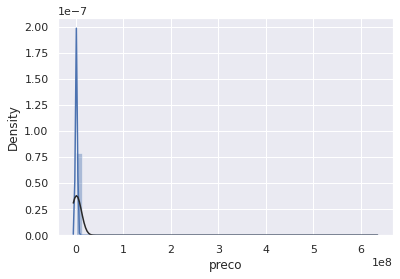

In [ ]:
sns.distplot(df_train['preco'], fit=stats.norm)

Percebe-se a presença de outliers. Para analisá-los deve-se utilizar o gráfico *boxplot*.

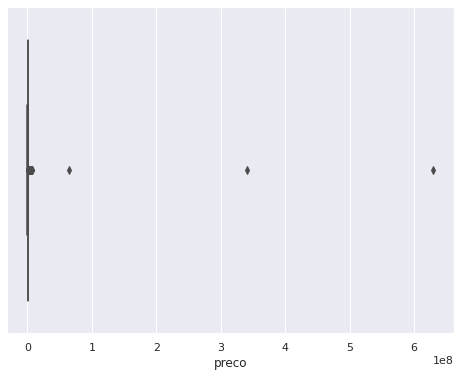

In [ ]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=df_train['preco'])

É clara a presença de muitos outliers. Foram removidos os registros com preço maior que 4000000.

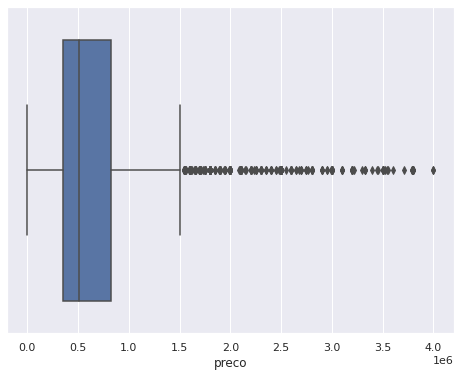

In [ ]:
df_train = df_train.drop(df_train[df_train['preco'] > 4*10**6].index)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=df_train['preco'])

Agora numa análise multivariável, o gráfico de correlações foi gerado. É possível perceber a alta correlação do número de quartos, suítes, vagas e área útil com o preço do imóvel.

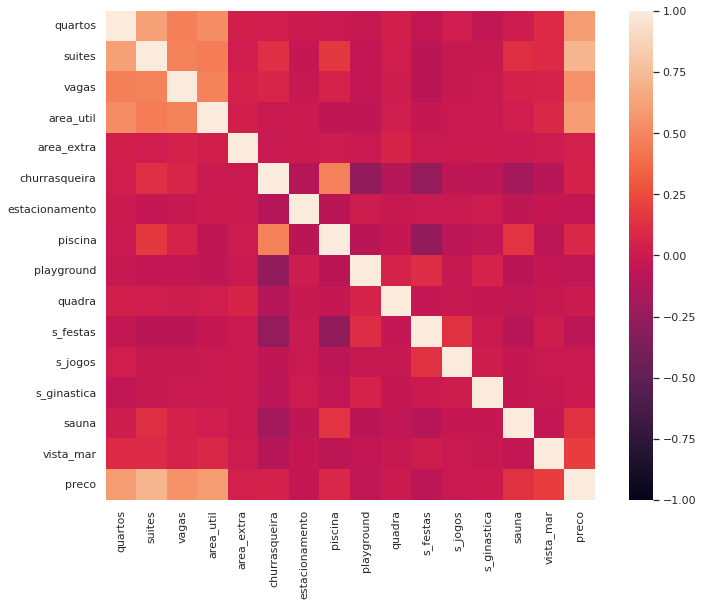

In [ ]:
corrmat = df_train.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmin=-1, vmax= 1, square=True)

Para analisar a relação da variável categórica *bairro* com o preço do imóvel, um gráfico boxplot foi gerado. Percebe-se que alguns bairros apresentam preços mais elevados.

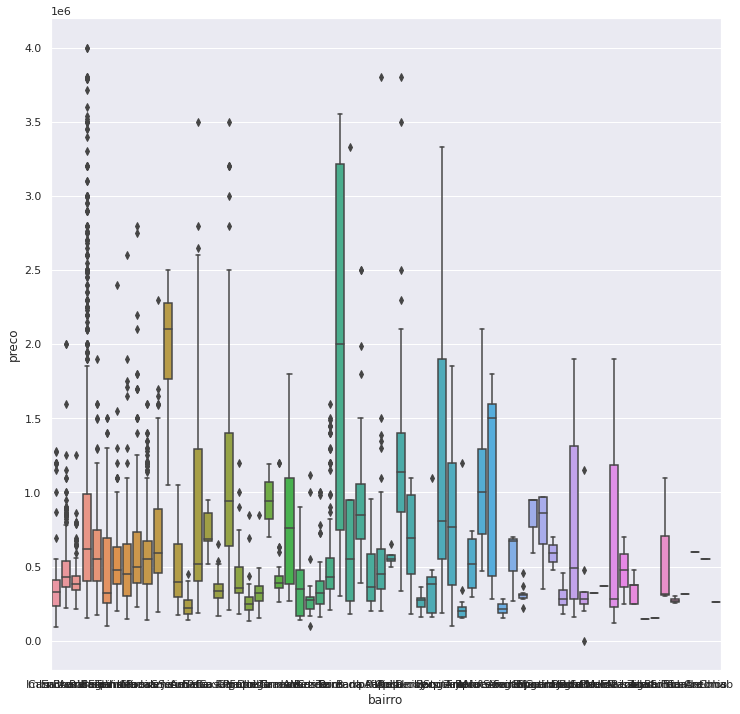

In [ ]:
data = pd.concat([df_train['preco'], df_train['bairro']], axis=1)
f, ax = plt.subplots(figsize=(12, 12))
fig = sns.boxplot(x='bairro', y="preco", data=data)

Para analisar a presença de dados faltantes, uma tabela com o número e porcentagem desses dados foi gerada. A tabela indica que não existem dados faltantes.

In [ ]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
preco,0,0.0
churrasqueira,0,0.0
bairro,0,0.0
tipo_vendedor,0,0.0
quartos,0,0.0
suites,0,0.0
vagas,0,0.0
area_util,0,0.0
area_extra,0,0.0
estacionamento,0,0.0


A função logarítmica foi escolhida para normalizar a distribuição das variáveis numéricas. A seguir é possível observar o antes e depois dessas variáveis.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


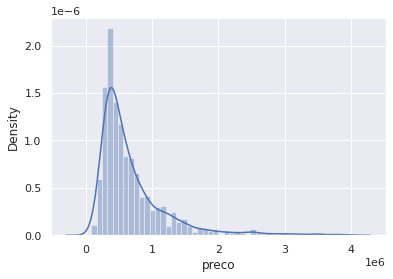

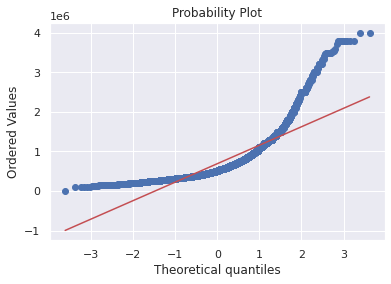

In [ ]:
sns.distplot(df_train['preco']);
fig = plt.figure()
res = stats.probplot(df_train['preco'], plot=plt)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


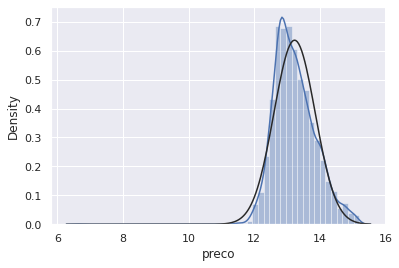

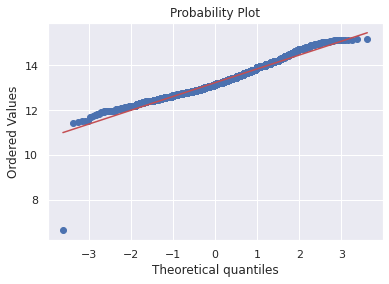

In [ ]:
df_train = df_train[df_train['preco'] > 0]
df_train['preco'] = np.log(df_train['preco'])
sns.distplot(df_train['preco'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(df_train['preco'], plot=plt)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


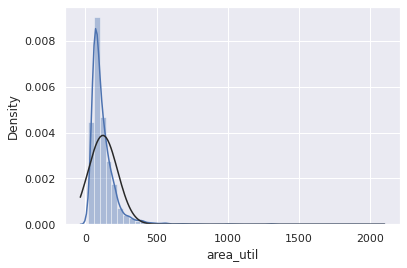

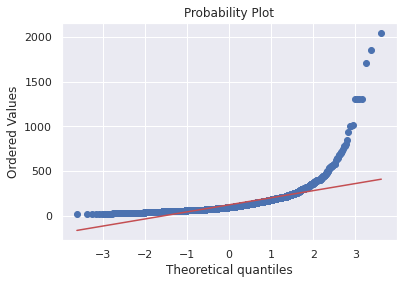

In [ ]:
sns.distplot(df_train['area_util'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(df_train['area_util'], plot=plt)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


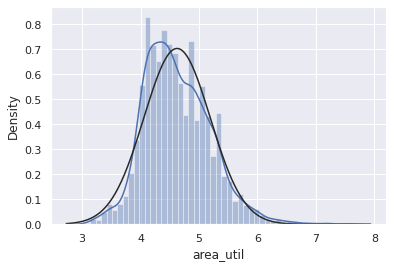

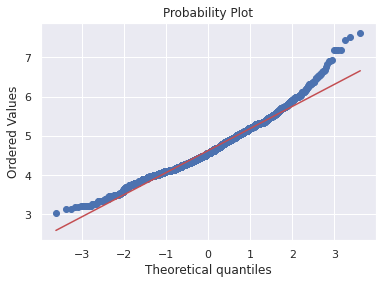

In [ ]:
df_train['area_util'] = np.log(df_train['area_util'])
df_test['area_util'] = np.log(df_test['area_util'])
sns.distplot(df_train['area_util'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(df_train['area_util'], plot=plt)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


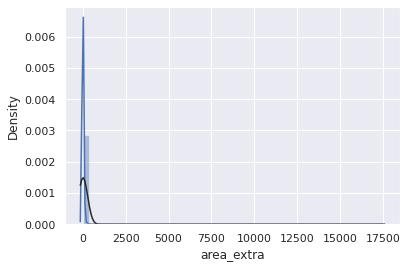

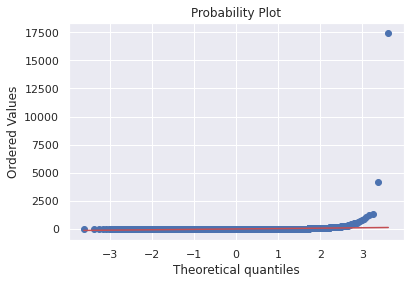

In [ ]:
sns.distplot(df_train['area_extra'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(df_train['area_extra'], plot=plt)

Como a variável *area_extra* possui linhas com valor 0, a função logarítmica não funcionaria para esses casos. Esse problema foi contornado criando uma variável binária para informar se o imóvel possui ou não área extra. Assim, os valores acima de 0 puderam ser normalizados.

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


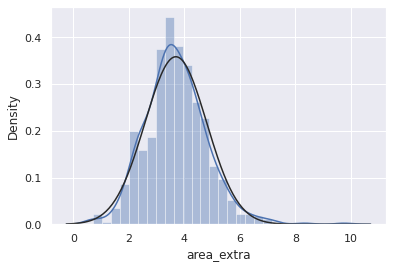

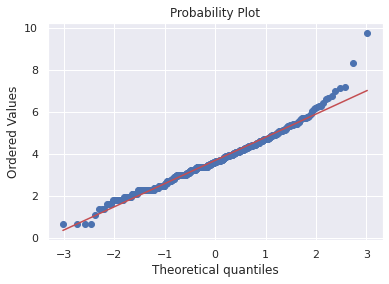

In [ ]:
df_train['tem_area_extra'] = pd.Series(len(df_train['area_extra']), index=df_train.index)
df_test['tem_area_extra'] = pd.Series(len(df_test['area_extra']), index=df_test.index)
df_train['tem_area_extra'] = 0 
df_test['tem_area_extra'] = 0 
df_train.loc[df_train['area_extra']>0,'tem_area_extra'] = 1
df_test.loc[df_test['area_extra']>0,'tem_area_extra'] = 1
df_train.loc[df_train['tem_area_extra']==1,'area_extra'] = np.log(df_train['area_extra'])
df_test.loc[df_test['tem_area_extra']==1,'area_extra'] = np.log(df_test['area_extra'])
sns.distplot(df_train[df_train['area_extra']>0]['area_extra'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['area_extra']>0]['area_extra'], plot=plt)

As variáveis categóricas *tipo* e *bairro* passaram pelo One-hot encoding.

In [ ]:
catvariable = ['tipo', 'bairro']
df_train = pd.get_dummies(data=df_train, columns=catvariable)
df_test = pd.get_dummies(data=df_test, columns=catvariable)


Como a variável *tipo_vendedor* possui somente 2 valores, a binarização foi aplicada.

In [ ]:
binarizador = LabelBinarizer()

df_train['tipo_vendedor'] = binarizador.fit_transform(df_train['tipo_vendedor'])
df_test['tipo_vendedor'] = binarizador.fit_transform(df_test['tipo_vendedor'])

Ao fazer o One-hot encoding nos 2 datasets, colunas novas foram criadas. Porém, o dataset de treino possui valores em *tipo* e *bairro* que o dataset de teste não tem e vice versa. Para tornar os 2 datasets iguais, as colunas faltantes foram criadas.

In [ ]:
test_missing_cols = list(set(df_train.columns) - set(df_test.columns))
train_missing_cols = list(set(df_test.columns) - set(df_train.columns))

for col in test_missing_cols:
  if col == 'preco':
    continue

  df_test[col] = 0

for col in train_missing_cols:
  df_train[col] = 0

A validação cruzada e a raiz do erro médio quadrático foram utilizados para testar e validar os modelos.

In [ ]:
y_train = df_train['preco']
x_train = df_train.drop(columns=['preco'])

kf = KFold(n_splits=5)

def cv(model, x=x_train, y=y_train):
    return -cross_val_score(model, x, y, cv=kf, scoring='neg_root_mean_squared_error')

In [ ]:
linear_regression = LinearRegression(fit_intercept=False)
score = cv(linear_regression)
print("linear_regression: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

linear_regression: 898805506.7178 ± 1164561173.7984


In [ ]:
dtree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=8)
score = cv(dtree)
print("dtree: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

dtree: 0.2934 ± 0.0321


In [ ]:
rf = RandomForestRegressor(n_estimators=200)
score = cv(rf)
print("rf: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

rf: 0.2514 ± 0.0265


In [ ]:
gbr = GradientBoostingRegressor(learning_rate=0.11)
score = cv(gbr)
print("gbr: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

gbr: 0.2571 ± 0.0270


In [ ]:
svr = svm.SVR(epsilon=0.05, C=0.1)
score = cv(svr)
print("svr: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

svr: 0.2764 ± 0.0237


In [ ]:
mlp = MLPRegressor(activation='logistic', hidden_layer_sizes=(50, 50))
score = cv(mlp)
print("mlp: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


mlp: 0.5006 ± 0.1403


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


O modelo do regressor de Random Forest foi o que apresentou menor erro e por isso foi escolhido para rodar no dataset de teste.

In [ ]:
rf.fit(x_train, y_train)

y_submission = rf.predict(df_test)

submission = pd.DataFrame({'Id': id_test, 'preco': y_submission})
submission['preco'] = np.exp(submission['preco'])
submission.to_csv('./submission.csv', index=False)